# Milestone 1: 
### Project: `Forecasting Air Quality Using Historical Pollution Data` 
### Task: `Data Preprocessing & EDA`

## Imports and load file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_raw = pd.read_csv("air_quality_data.csv")
df_raw.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


## Quick inspection

In [2]:
df_raw.shape
df_raw.columns.tolist()
df_raw.info()
df_raw.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


Xylene        18109
PM10          11140
NH3           10328
Toluene        8041
Benzene        5623
AQI            4681
AQI_Bucket     4681
PM2.5          4598
NOx            4185
O3             4022
SO2            3854
NO2            3585
NO             3582
CO             2059
Date              0
City              0
dtype: int64

## Convert numeric-like columns

In [3]:
df = df_raw.copy()

# keep date/time columns aside
date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
other_cols = [c for c in df.columns if c not in date_cols]

# convert others to numeric where possible (commas -> dots, coerce errors)
for c in other_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', '.', regex=False), errors='coerce')

# replace -200 sentinel (common in this dataset) with NaN
df.replace(-200, np.nan, inplace=True)

# check missing after replacement
df.isnull().sum().sort_values(ascending=False)


City          29531
AQI_Bucket    29531
Xylene        18109
PM10          11140
NH3           10328
Toluene        8041
Benzene        5623
AQI            4681
PM2.5          4598
NOx            4185
O3             4022
SO2            3854
NO2            3585
NO             3582
CO             2059
Date              0
dtype: int64

## Parse Date + Time → Datetime index

In [4]:
# detect columns
date_col = next((c for c in df.columns if 'date' in c.lower()), None)
time_col = next((c for c in df.columns if 'time' in c.lower()), None)

if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')

if time_col is not None:
    df[time_col] = df[time_col].astype(str).str.replace('.', ':', regex=False)

# combine into Datetime
if date_col and time_col:
    df['Datetime'] = pd.to_datetime(df[date_col].dt.strftime("%Y-%m-%d") + ' ' + df[time_col], errors='coerce')
elif date_col:
    df['Datetime'] = df[date_col]
else:
    raise RuntimeError("No Date/Time column found — check your CSV.")

# drop rows where Datetime couldn't be parsed, set as index
df = df[~df['Datetime'].isnull()].copy()
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)
df.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Datetime,,,,,,,,,,,,,,,,
2015-01-01,NaN,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
2015-01-01,NaN,2015-01-01,NaN,NaN,16.30,15.39,22.68,4.59,1.17,9.20,11.35,0.17,NaN,NaN,NaN,NaN
2015-01-01,NaN,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,NaN
2015-01-01,NaN,2015-01-01,NaN,NaN,2.11,13.46,4.57,NaN,12.15,169.57,25.92,1.35,3.93,NaN,NaN,NaN
2015-01-01,NaN,2015-01-01,NaN,NaN,NaN,NaN,27.38,NaN,0.00,NaN,NaN,0.00,0.00,0.00,NaN,NaN


## Duplicates and missing summary

In [5]:
print("Duplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
n = len(df)
missing = df.isnull().sum().sort_values(ascending=False)
pd.concat([missing, (missing / n * 100).round(2)], axis=1, keys=['missing_count','missing_percent'])


Duplicates: 174


,missing_count,missing_percent
City,11416,100.00
AQI_Bucket,11416,100.00
Xylene,6933,60.73
PM10,4210,36.88
NH3,3899,34.15
Toluene,2999,26.27
Benzene,2018,17.68
AQI,1676,14.68
PM2.5,1655,14.50
NOx,1453,12.73


## Outliers

In [19]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outlier_rows = []
for c in num_cols:
    s = df[c].dropna()
    if s.empty:
        outlier_rows.append({'column': c, 'outlier_count': 0, 'lower': None, 'upper': None})
        continue
    Q1 = s.quantile(0.25); Q3 = s.quantile(0.75); IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR; upper = Q3 + 1.5*IQR
    oc = int(((df[c] < lower) | (df[c] > upper)).sum())
    outlier_rows.append({'column': c, 'outlier_count': oc, 'lower': float(lower), 'upper': float(upper)})

pd.DataFrame(outlier_rows).sort_values('outlier_count', ascending=False)


,column,outlier_count,lower,upper
8,SO2,1021,-8.49000,29.35000
7,CO,984,-0.91500,2.88500
3,NO,970,-16.40500,42.35500
11,Toluene,954,-12.49500,22.42500
1,PM2.5,781,-49.32000,160.36000
5,NOx,718,-28.52500,82.31500
10,Benzene,659,-4.36125,7.58875
13,AQI,515,-111.50000,404.50000
4,NO2,472,-26.36250,75.93750
2,PM10,434,-85.81625,295.03375


## Example: outliers for PM2.5

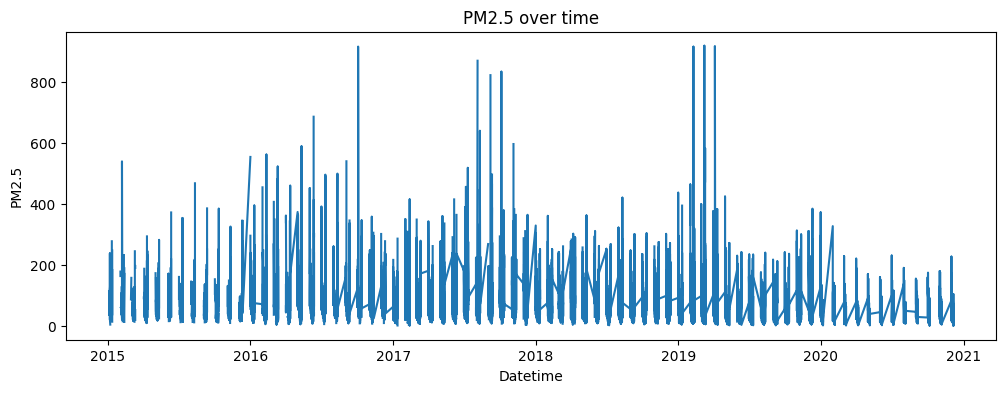

In [13]:
import matplotlib.pyplot as plt

target = "PM2.5"

plt.figure(figsize=(12,4))
plt.plot(df.index, df[target])
plt.title(f"{target} over time")
plt.xlabel("Datetime")
plt.ylabel(target)
plt.show()

## Correlation matrix (numeric columns)

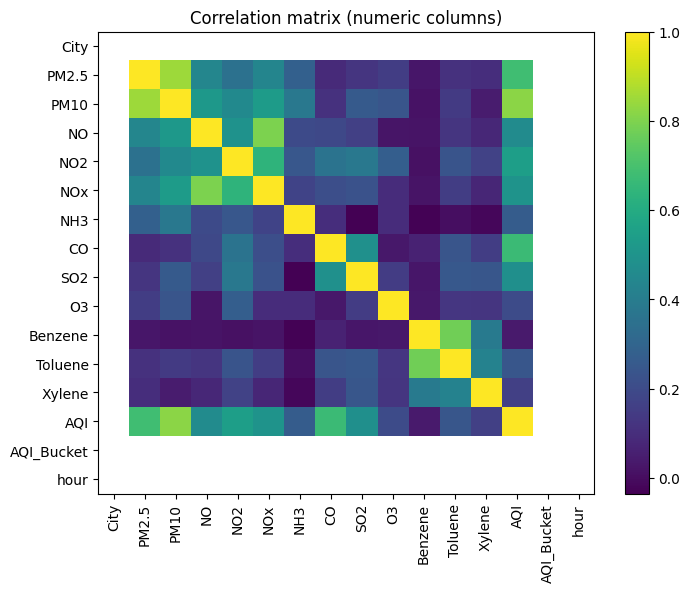

In [17]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation matrix (numeric columns)")
plt.show()


## Cleaned file

In [18]:
df.to_csv("AirQuality_cleaned.csv", index=True)